In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Autoreload all modules ###
%load_ext autoreload
%autoreload 2


### Import libraries ###

# import general libraries
import os
import sys
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# import torch libraries
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# import sklearn libraries
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc


### Set base path ###
base_path = Path(os.getcwd())
while not (base_path / '.git').exists():
    base_path = base_path.parent
print('Base path: ', base_path)

### import custom libraries
sys.path.append(str(base_path) + '/src/data/datasets/')
sys.path.append(str(base_path) + '/src/data/')
sys.path.append(str(base_path) + '/src/training/')
sys.path.append(str(base_path) + '/src/evaluation/')
sys.path.append(str(base_path) + '/src/visualization/')
sys.path.append(str(base_path) + '/src/models/')

from data_modules import UkraineDataModule
from dataset import UkraineDataset
from model_eval_plots import plot_pred_gt, plot_img_mask, plot_polygons, percentile_stretch
from baselines import spatial_correction, nbr
from cd_model import CDModel
from pytorch_lightning import Trainer
from pixel_metrics import ConfuseMatrixMeter
from polygon_metrics import PolygonConfuseMatrixMeter, polygonize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Base path:  /scratch/yves/Thesis/Yves-MSc-Thesis


/scratch/yves/miniconda/envs/mscthesis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overall scores

Load model and data information

In [5]:
model_metadata_path = str(base_path) + '/models/fitted_models_metadata/UKR_cd/'
model_path = str(base_path) + '/models/fitted_models/UKR_cd/'
root_path = str(base_path) + '/data/UKR/final_datasets/change_new/'
model_metadata_file = 'Unet_ukr_cd_4.json'

with open(os.path.join(model_metadata_path, model_metadata_file), 'r') as file:
    config = json.load(file)

data_module = UkraineDataModule(root_path, batch_size=config['batch_size'], num_workers=8, mode = config['mode'],
                                normalize=True, return_cloud_mask=True, sentinel_type=config["sentinel_type"], 
                                indices=None, dilate_mask=config['dilate_mask'], bands=config['bands'], file_type='tif')

Run test set evaluation

In [6]:
model = CDModel(model = config['model_name'])
best_model_path = os.path.join(model_path, model_metadata_file.replace('.json', '.ckpt'))
model = CDModel.load_from_checkpoint(best_model_path)
model.hparams['return_results'] = True

MyTrainer = Trainer(accelerator = 'gpu', devices = 1)
results = MyTrainer.test(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using Unet from fully_conv_models
Using Unet from fully_conv_models


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using test dataloader
Testing DataLoader 0: 100%|██████████| 439/439 [00:11<00:00, 38.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_pixel    │    0.9982238411903381     │
│    test_accuracy_poly     │    0.7866109013557434     │
│      test_f1_0_pixel      │     0.99910968542099      │
│      test_f1_0_poly       │    0.7860139012336731     │
│      test_f1_1_pixel      │    0.6395629048347473     │
│      test_f1_1_poly       │     0.787204384803772     │
│    test_mean_f1_pixel     │    0.8193362951278687     │
│     test_mean_f1_poly     │    0.7866091728210449     │
│    test_mean_iou_pixel    │    0.7341684103012085     │
│    test_mean_iou_poly     │    0.31978824734687805    │
└───────────────────────────┴───────────────────────────┘

## Cloud evaluation

Load model and data information

In [ ]:
model_metadata_path = str(base_path) + '/models/fitted_models_metadata/UKR_cd/'
model_path = str(base_path) + '/models/fitted_models/UKR_cd/'
root_path = str(base_path) + '/data/UKR/final_datasets/change_new/'
model_metadata_file = 'Unet_ukr_cd_4.json'

with open(os.path.join(model_metadata_path, model_metadata_file), 'r') as file:
    config = json.load(file)

data_module = UkraineDataModule(root_path, batch_size=config['batch_size'], num_workers=8, mode = config['mode'],
                                normalize=True, return_cloud_mask=True, sentinel_type=config["sentinel_type"], 
                                indices=None, dilate_mask=config['dilate_mask'], bands=config['bands'], file_type='tif')

Run test set evaluation

In [7]:
mymodel = CDModel(model = config['model_name'])
best_model_path = os.path.join(model_path, model_metadata_file.replace('json', 'ckpt'))
mymodel = CDModel.load_from_checkpoint(best_model_path)
mymodel.hparams['use_custom_test'] = True
mymodel.hparams['plot_indices'] = range(0, 439)

MyTrainer = Trainer(accelerator = 'gpu', devices = 1)
results = MyTrainer.test(mymodel, datamodule=data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using Unet from fully_conv_models
Using Unet from fully_conv_models
Using test dataloader
Testing DataLoader 0: 100%|██████████| 439/439 [00:05<00:00, 87.24it/s]


Cloudy vs clear evaluation

In [8]:
### Initialize confusion matrix meters
# Non cloudy
non_cloudy_pix_cm = ConfuseMatrixMeter(n_class=2)
non_cloudy_00_cm = ConfuseMatrixMeter(n_class=2)
non_cloudy_00_pcm_001 = PolygonConfuseMatrixMeter(iou_threshold=0.01)
non_cloudy_00_pcm_010 = PolygonConfuseMatrixMeter(iou_threshold=0.10)
non_cloudy_00_pcm_030 = PolygonConfuseMatrixMeter(iou_threshold=0.30)

# Cloudy
cloudy_pix_cm = ConfuseMatrixMeter(n_class=2)
cloudy_00_cm = ConfuseMatrixMeter(n_class=2)
cloudy_00_pcm_001 = PolygonConfuseMatrixMeter(iou_threshold=0.01)
cloudy_00_pcm_010 = PolygonConfuseMatrixMeter(iou_threshold=0.10)
cloudy_00_pcm_030 = PolygonConfuseMatrixMeter(iou_threshold=0.30)

# Overall
overall_cm = ConfuseMatrixMeter(n_class=2)
overall_pcm_001 = PolygonConfuseMatrixMeter(iou_threshold=0.01)
overall_pcm_010 = PolygonConfuseMatrixMeter(iou_threshold=0.10)
overall_pcm_030 = PolygonConfuseMatrixMeter(iou_threshold=0.30)


#### Initialize lists for AUC calculation
preds_probs_overall = []
preds_probs_cloudy_pix = []
preds_probs_non_cloudy_pix = []
preds_probs_cloudy_00 = []
preds_probs_non_cloudy_00 = []

gts_overall = []
gts_cloudy_pix = []
gts_non_cloudy_pix = []
gts_cloudy_00 = []
gts_non_cloudy_00 = []


for i in range(len(mymodel.test_images_A) - 1):

    # Cloudy images
    if (mymodel.test_clouds_A[i].sum() + mymodel.test_clouds_B[i].sum()) > 0:
        preds = mymodel.test_preds[i].flatten()
        preds_probs = mymodel.test_preds_probs[i][0, 1, :, :].cpu().numpy().flatten()
        gts = mymodel.test_targets[i].flatten()

        pred_polygons = polygonize(mymodel.test_preds[i])
        gt_polygons = polygonize(mymodel.test_targets[i])

        cm = confusion_matrix(gts, preds, labels=[0, 1])
        cloudy_00_cm.update(cm)

        cloudy_00_pcm_001.update(gt_polygons, pred_polygons)
        cloudy_00_pcm_010.update(gt_polygons, pred_polygons)
        cloudy_00_pcm_030.update(gt_polygons, pred_polygons)

        preds_probs_cloudy_00.append(preds_probs)
        gts_cloudy_00.append(gts)


    # Non cloudy images
    if (mymodel.test_clouds_A[i].sum() + mymodel.test_clouds_B[i].sum()) == 0:
        preds = mymodel.test_preds[i].flatten()
        preds_probs = mymodel.test_preds_probs[i][0, 1, :, :].cpu().numpy().flatten()
        gts = mymodel.test_targets[i].flatten()

        pred_polygons = polygonize(mymodel.test_preds[i])
        gt_polygons = polygonize(mymodel.test_targets[i])

        cm = confusion_matrix(gts, preds, labels=[0, 1])
        non_cloudy_00_cm.update(cm)

        non_cloudy_00_pcm_001.update(gt_polygons, pred_polygons)
        non_cloudy_00_pcm_010.update(gt_polygons, pred_polygons)
        non_cloudy_00_pcm_030.update(gt_polygons, pred_polygons)

        preds_probs_non_cloudy_00.append(preds_probs)
        gts_non_cloudy_00.append(gts)

    # Overall results
    preds = mymodel.test_preds[i].flatten()
    preds_probs = mymodel.test_preds_probs[i][0, 1, :, :].cpu().numpy().flatten()
    gts = mymodel.test_targets[i].flatten()
    cloud_A = mymodel.test_clouds_A[i].flatten()
    cloud_B = mymodel.test_clouds_B[i].flatten()

    # Cloudy and non cloudy pixels
    preds_cloudy = preds[(cloud_A == 1) | (cloud_B == 1)]
    preds_probs_cloudy = preds_probs[(cloud_A == 1) | (cloud_B == 1)]
    gts_cloudy = gts[(cloud_A == 1) | (cloud_B == 1)]
    preds_non_cloudy = preds[(cloud_A == 0) & (cloud_B == 0)]
    preds_probs_non_cloudy = preds_probs[(cloud_A == 0) & (cloud_B == 0)]
    gts_non_cloudy = gts[(cloud_A == 0) & (cloud_B == 0)]

    cm = confusion_matrix(gts, preds, labels=[0, 1])
    cm_cloudy = confusion_matrix(gts_cloudy, preds_cloudy, labels=[0, 1])
    cm_non_cloudy = confusion_matrix(gts_non_cloudy, preds_non_cloudy, labels=[0, 1])

    cloudy_pix_cm.update(cm_cloudy)
    non_cloudy_pix_cm.update(cm_non_cloudy)
    overall_cm.update(cm)

    pred_polygons = polygonize(mymodel.test_preds[i])
    gt_polygons = polygonize(mymodel.test_targets[i])

    overall_pcm_001.update(gt_polygons, pred_polygons)
    overall_pcm_010.update(gt_polygons, pred_polygons)
    overall_pcm_030.update(gt_polygons, pred_polygons)

    # Append results to AUC lists
    preds_probs_overall.append(preds_probs)
    gts_overall.append(gts)
    preds_probs_cloudy_pix.append(preds_probs_cloudy)
    gts_cloudy_pix.append(gts_cloudy)
    preds_probs_non_cloudy_pix.append(preds_probs_non_cloudy)
    gts_non_cloudy_pix.append(gts_non_cloudy)

# Concatenate AUC lists
preds_probs_overall = np.concatenate(preds_probs_overall)
preds_probs_cloudy_pix = np.concatenate(preds_probs_cloudy_pix)
preds_probs_non_cloudy_pix = np.concatenate(preds_probs_non_cloudy_pix)
preds_probs_cloudy_00 = np.concatenate(preds_probs_cloudy_00)
preds_probs_non_cloudy_00 = np.concatenate(preds_probs_non_cloudy_00)  

gts_overall = np.concatenate(gts_overall)
gts_cloudy_pix = np.concatenate(gts_cloudy_pix)
gts_non_cloudy_pix = np.concatenate(gts_non_cloudy_pix)
gts_cloudy_00 = np.concatenate(gts_cloudy_00)
gts_non_cloudy_00 = np.concatenate(gts_non_cloudy_00)


### Calculate AUC
precision, recall, _ = precision_recall_curve(gts_overall, preds_probs_overall)
auc_score = auc(recall, precision)

precision_cloudy_pix, recall_cloudy_pix, _ = precision_recall_curve(gts_cloudy_pix, preds_probs_cloudy_pix)
auc_score_cloudy_pix = auc(recall_cloudy_pix, precision_cloudy_pix)

precision_non_cloudy_pix, recall_non_cloudy_pix, _ = precision_recall_curve(gts_non_cloudy_pix, preds_probs_non_cloudy_pix)
auc_score_non_cloudy_pix = auc(recall_non_cloudy_pix, precision_non_cloudy_pix)

precision_cloudy_00, recall_cloudy_00, _ = precision_recall_curve(gts_cloudy_00, preds_probs_cloudy_00)
auc_score_cloudy_00 = auc(recall_cloudy_00, precision_cloudy_00)

precision_non_cloudy_00, recall_non_cloudy_00, _ = precision_recall_curve(gts_non_cloudy_00, preds_probs_non_cloudy_00)
auc_score_non_cloudy_00 = auc(recall_non_cloudy_00, precision_non_cloudy_00)


print("Pixel Metrics Results")
print("Overall")
print(overall_cm.get_scores())
print("Non Cloudy Pixels")
print(non_cloudy_pix_cm.get_scores())
print("Cloudy Pixels")
print(cloudy_pix_cm.get_scores())
print("Non Cloudy 0.0")
print(non_cloudy_00_cm.get_scores())
print("Cloudy 0.0")
print(cloudy_00_cm.get_scores())
print("-----------------------------------")
print(f"Overall AUC: {auc_score}")
print(f"Cloudy Pixels AUC: {auc_score_cloudy_pix}")
print(f"Non Cloudy Pixels AUC: {auc_score_non_cloudy_pix}")
print(f"Cloudy 00 AUC: {auc_score_cloudy_00}")
print(f"Non Cloudy 00 AUC: {auc_score_non_cloudy_00}")
print("-----------------------------------")
print("-----------------------------------")
print("Polygon Metrics Results")
print("Overall PCM 0.01")
print(overall_pcm_001.get_scores())
print("Overall PCM 0.10")
print(overall_pcm_010.get_scores())
print("Overall PCM 0.30")
print(overall_pcm_030.get_scores())
print("-----------------------------------")
print("Non Cloudy PCM 0.01")
print(non_cloudy_00_pcm_001.get_scores())
print("Non Cloudy PCM 0.10")
print(non_cloudy_00_pcm_010.get_scores())
print("Non Cloudy PCM 0.30")
print(non_cloudy_00_pcm_030.get_scores())
print("-----------------------------------")
print("Cloudy PCM 0.01")
print(cloudy_00_pcm_001.get_scores())
print("Cloudy PCM 0.10")
print(cloudy_00_pcm_010.get_scores())
print("Cloudy PCM 0.30")
print(cloudy_00_pcm_030.get_scores())


Pixel Metrics Results
Overall
{'acc': 0.9982243780431639, 'miou': 0.7344906636033005, 'mf1': 0.8196342416311233, 'iou_0': 0.9982215691581583, 'iou_1': 0.4707597580484428, 'F1_0': 0.9991099335666602, 'F1_1': 0.6401585496955865, 'precision_0': 0.9997140069065498, 'precision_1': 0.5144809391109663, 'recall_0': 0.9985067088692194, 'recall_1': 0.8470849500914909}
Non Cloudy Pixels
{'acc': 0.9981780078028833, 'miou': 0.7387138271548442, 'mf1': 0.8235262467541876, 'iou_0': 0.9981749475351758, 'iou_1': 0.47925270677451265, 'F1_0': 0.9990865806982835, 'F1_1': 0.6479659128100917, 'precision_0': 0.9997070379934738, 'precision_1': 0.5228954178708732, 'recall_0': 0.9984670121469456, 'recall_1': 0.8516773697626757}
Cloudy Pixels
{'acc': 0.9988608707771012, 'miou': 0.5872091526721981, 'mf1': 0.6490548670989543, 'iou_0': 0.9988605943943127, 'iou_1': 0.17555771095008335, 'F1_0': 0.9994299128461913, 'F1_1': 0.2986798213517174, 'precision_0': 0.9998094714172783, 'precision_1': 0.20359955004259225, 'recal

## Visual comparison against baseline

In [14]:
root_path = str(base_path) + '/data/UKR/final_datasets/change_new/'
ukr_dataset = UkraineDataset(root_path, mode = "test", normalize = False,  return_cloud_mask = True, 
                 sentinel_type = "S2", indices = None, dilate_mask = True, bands = [1, 2, 3, 4, 5, 6, 7], file_type = "tif")
    

/scratch/yves/Thesis/Yves-MSc-Thesis/data/UKR/final_datasets/change_new/test/S2_A/*.tif
Number of images: 439


In [ ]:
for i in range(10, 20): # 60-70


    imageA = ukr_dataset[i]['A'].numpy()
    imageB = ukr_dataset[i]['B'].numpy()
    mask = ukr_dataset[i]['mask'].numpy()
    clouds_A = ukr_dataset[i]['cloud_mask_A'].numpy()
    clouds_B = ukr_dataset[i]['cloud_mask_B'].numpy()
    combined_cloud_mask = (clouds_A == 0) & (clouds_B == 0)

    # calculate ndvi
    nbr_A = nbr(imageA)
    nbr_B = nbr(imageB)

    # calculate distance
    distance = nbr_A - nbr_B
    distance = np.where(combined_cloud_mask, distance, np.nan)
    distance_binary = distance > 0.1

    # apply spatial correction
    distance_binary = spatial_correction(distance_binary, radius=1)

    pred = mymodel.test_preds[i]
    gt = mymodel.test_targets[i]

    imageA = mymodel.test_images_A[i]
    imageB = mymodel.test_images_B[i]

    rgbA = imageA[:3].transpose(1, 2, 0)
    rgbB = imageB[:3].transpose(1, 2, 0)

    rgbA = percentile_stretch(rgbA, 2, 98)
    rgbB = percentile_stretch(rgbB, 2, 98)

    # create overlay images
    gt_overlay = np.where(gt[..., None] == 1, [1, 0, 0], rgbB)
    pred_overlay = np.where(pred[..., None] == 1, [0, 0, 1], rgbB)
    distance_overlay = np.where(distance_binary[..., None] == 1, [1, 1, 0], rgbB)

    # plot the image
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))
    for i in range(2):  
        for j in range(3):  
            ax[i][j].set_xticks([]) 
            ax[i][j].set_yticks([])


    font_size = 18  

    ax[0][0].imshow(rgbA)
    ax[0][0].set_title("Image A", fontsize=font_size)
    ax[0][1].imshow(rgbB)
    ax[0][1].set_title("Image B", fontsize=font_size)
    ax[1][0].imshow(gt_overlay)
    ax[1][0].set_title("Ground Truth Overlay B ", fontsize=font_size)
    ax[1][1].imshow(pred_overlay)
    ax[1][1].set_title("FC-EF Overlay B", fontsize=font_size)
    ax[1][2].imshow(distance_overlay)
    ax[1][2].set_title("NBR Overlay B", fontsize=font_size)
    plt.show()


## Model comparison

Run test set evaluation

In [ ]:
# Paths
model_metadata_path = str(base_path) + '/models/fitted_models_metadata/UKR_cd/'
model_path = str(base_path) + '/models/fitted_models/UKR_cd/'
root_path = str(base_path) + '/data/UKR/final_datasets/change_new/'

# Model metadata files
model_metadata_files = [
    'Unet_ukr_cd_1.json',
    'Unet_ukr_cd_2.json',
    'Unet_ukr_cd_3.json',
]

# Function to load configuration
def load_config(metadata_file):
    with open(os.path.join(model_metadata_path, metadata_file), 'r') as file:
        return json.load(file)

# Initialize models and data modules
models = []
data_modules = []

for metadata_file in model_metadata_files:
    # Load config for each model
    config = load_config(metadata_file)

    # Create data module based on the config
    data_module = UkraineDataModule(
        root_path, 
        batch_size=config['batch_size'], 
        num_workers=8, 
        mode=config['mode'],
        normalize=True, 
        return_cloud_mask=True,
        sentinel_type=config["sentinel_type"], 
        indices=None, 
        dilate_mask=config['dilate_mask'],
        bands=config['bands'], 
        file_type='tif'
    )
    
    # Load model from checkpoint
    model_ckpt_path = os.path.join(model_path, metadata_file.replace('.json', '.ckpt'))
    model = CDModel.load_from_checkpoint(model_ckpt_path)
    
    # Modify model hyperparameters as needed
    model.hparams['use_custom_test'] = True
    model.hparams['plot_indices'] = range(0, 439)
    
    # Append model and data module to their respective lists
    models.append(model)
    data_modules.append(data_module)

# Initialize trainer
MyTrainer = Trainer(accelerator='gpu', devices=1)

# Test each model
results = []
for model, data_module in zip(models, data_modules):
    result = MyTrainer.test(model, datamodule=data_module)
    results.append(result)


### PL-curves

In [ ]:
# Initialize empty lists to store precision, recall, and AUC for each model
model_names = [f"Model {i+1}" for i in range(len(model_metadata_files))]

precisions = []
recalls = []
aucs = []

# Loop through each model and data module to calculate and plot the Precision-Recall curve
for model, data_module, model_name in zip(models, data_modules, model_names):
    all_preds = []
    all_targets = []

    # Use the test data to collect predictions and targets
    for probs, targets in zip(model.test_preds_probs, model.test_targets):
        # Extract deforestation probability (class 1) from the tensor [1, 2, 224, 224]
        deforestation_probs = probs[0, 1, :, :].cpu().numpy() 

        # Flatten the probabilities and targets into 1D arrays
        deforestation_probs_flat = deforestation_probs.flatten()
        targets_flat = targets.flatten()

        # Append to the list of all predictions and targets
        all_preds.append(deforestation_probs_flat)
        all_targets.append(targets_flat)

    # Concatenate all predictions and targets across all samples
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_targets, all_preds)

    precisions.append(precision)
    recalls.append(recall)
    
    # Calculate AUC for the Precision-Recall curve
    auc_pr = auc(recall, precision)
    aucs.append(auc_pr)


In [ ]:
min_recall_threshold = 0.01
plt.figure(figsize=(12, 8))

model_names = ["FC-EF Multi-modal", "FC-EF S2", "FC-EF S1"]

color_map = {
    "FC-EF Multi-modal": "blue",
    "FC-EF S2": "green",
    "FC-EF S1": "red",
}

def plot_f1_contours():
    # Create a grid of precision and recall values
    precision_vals = np.linspace(0, 1, 100)
    recall_vals = np.linspace(0, 1, 100)
    P, R = np.meshgrid(precision_vals, recall_vals)
    
    # Calculate F1 score for each combination of precision and recall
    F1 = 2 * P * R / (P + R + 1e-6)  # Add a small epsilon to avoid division by zero
    
    # Plot the contour lines for F1 scores
    f1_levels = np.linspace(0.1, 0.9, 9)  # F1 score levels from 0.1 to 0.9
    contours = plt.contour(R, P, F1, levels=f1_levels, alpha=0.6, colors=['gray'], linewidths=1)
    
    # Label the contour lines with their F1 score values
    plt.clabel(contours, inline=True, fontsize=10, fmt="f1=%.1f")


# Apply the filter for each model
for i in range(len(recalls)):
    valid_idx = recalls[i] > min_recall_threshold
    filtered_recalls = recalls[i][valid_idx]
    filtered_precisions = precisions[i][valid_idx]
    
    model_name = model_names[i]
    model_color = color_map[model_name]
    
    # Plot the Precision-Recall curve with the corresponding color
    plt.plot(filtered_recalls, filtered_precisions, marker='.', markersize=4, color=model_color, label=f'{model_name} (AUC = {aucs[i]:.4f})')


plot_f1_contours()

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=12)
plt.show()


### Comparison on patches

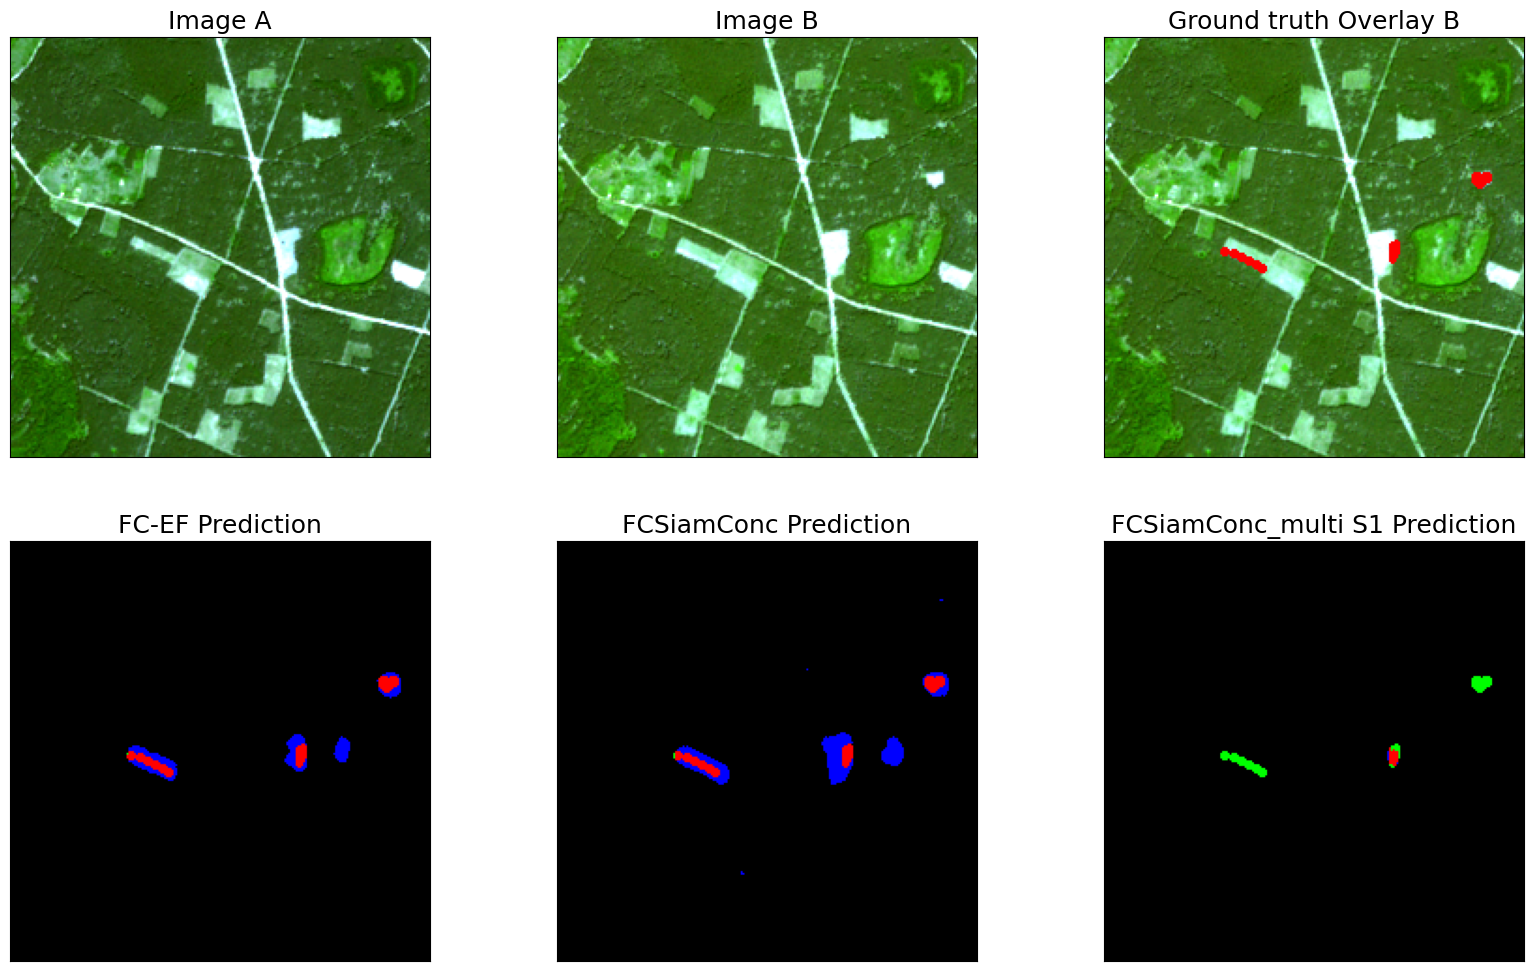

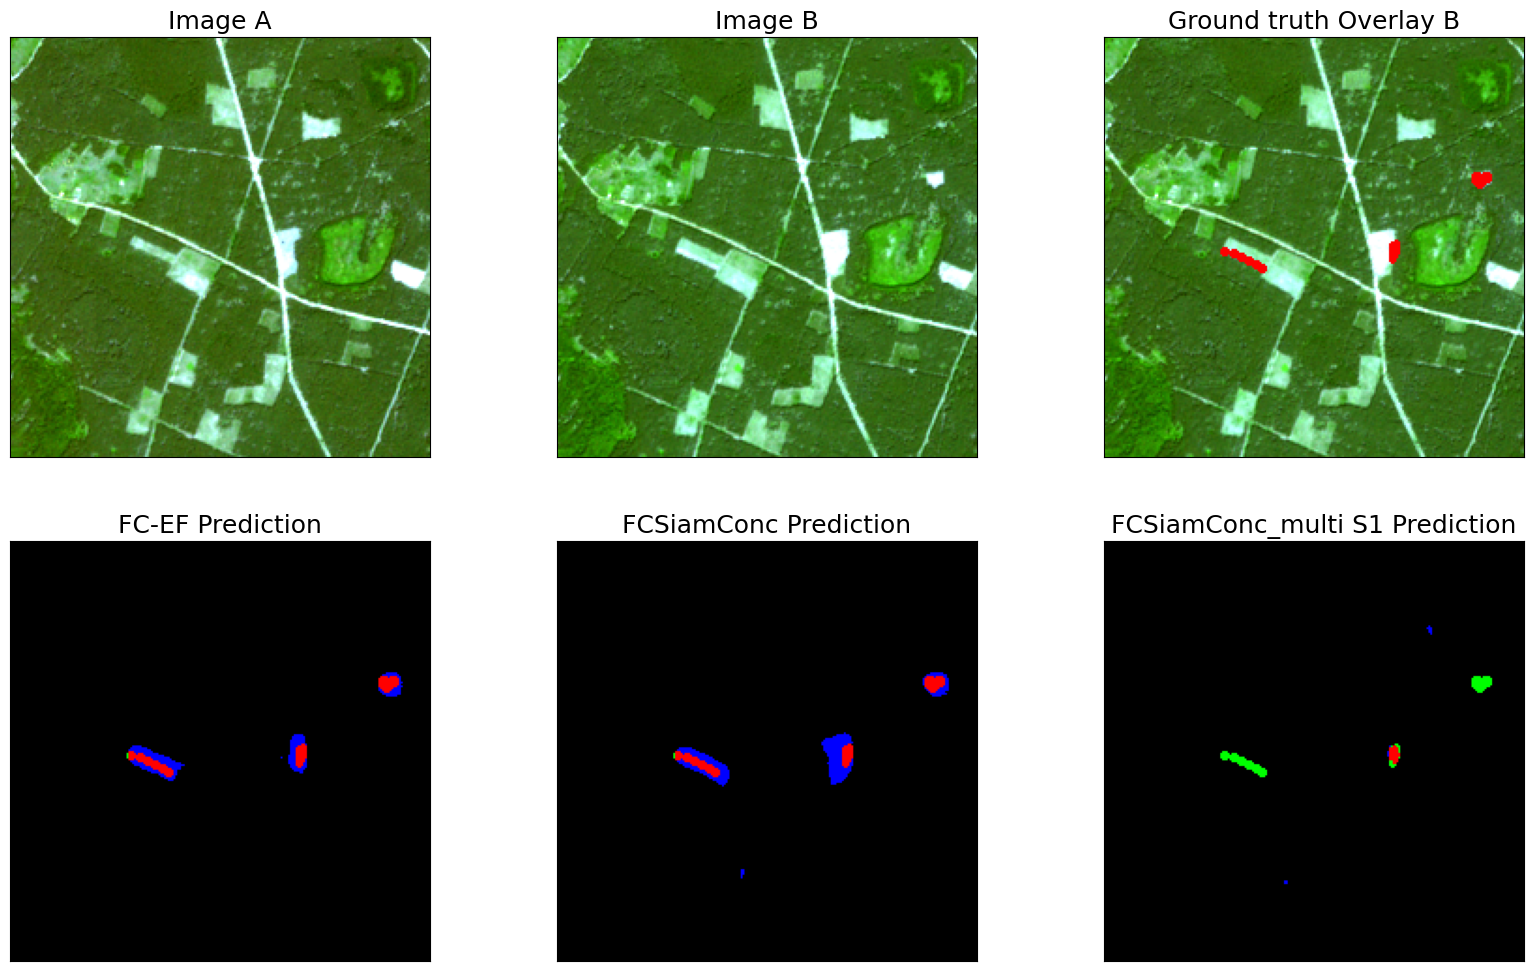

In [21]:
model_1 = models[0]
model_2 = models[1]
model_3 = models[2]


for i in range(100, 102):
    imageA = model_1.test_images_A[i]
    imageB = model_1.test_images_B[i]
    preds_1 = model_1.test_preds[i]
    preds_2 = model_2.test_preds[i]
    preds_3 = model_3.test_preds[i]
    gt = model_1.test_targets[i]

    rgbA = imageA[:3].transpose(1, 2, 0)
    rgbB = imageB[:3].transpose(1, 2, 0)

    rgbA = percentile_stretch(rgbA, 2, 98)
    rgbB = percentile_stretch(rgbB, 2, 98)

    # TP: Red [1, 0, 0]
    # FP: Blue [0, 0, 1]
    # FN: Green [0, 1, 0]
    
    # Ground truth overlay
    gt_overlay = np.copy(rgbB)
    gt_overlay = np.where(gt[..., None] == 1, [1, 0, 0], gt_overlay)
    
    # Predictions overlay for model 1, 2, and 3
    pred_overlay_1 = np.zeros_like(rgbB)
    pred_overlay_2 = np.zeros_like(rgbB)
    pred_overlay_3 = np.zeros_like(rgbB)

    # TP (gt == 1, preds == 1) - Red
    tp_1 = (gt == 1) & (preds_1 == 1)
    tp_2 = (gt == 1) & (preds_2 == 1)
    tp_3 = (gt == 1) & (preds_3 == 1)
    
    # FP (gt == 0, preds == 1) - Blue
    fp_1 = (gt == 0) & (preds_1 == 1)
    fp_2 = (gt == 0) & (preds_2 == 1)
    fp_3 = (gt == 0) & (preds_3 == 1)
    
    # FN (gt == 1, preds == 0) - Green
    fn_1 = (gt == 1) & (preds_1 == 0)
    fn_2 = (gt == 1) & (preds_2 == 0)
    fn_3 = (gt == 1) & (preds_3 == 0)

    # Apply the color for each overlay
    pred_overlay_1[tp_1] = [1, 0, 0]  # TP in red
    pred_overlay_1[fp_1] = [0, 0, 1]  # FP in blue
    pred_overlay_1[fn_1] = [0, 1, 0]  # FN in green

    pred_overlay_2[tp_2] = [1, 0, 0]  # TP in red
    pred_overlay_2[fp_2] = [0, 0, 1]  # FP in blue
    pred_overlay_2[fn_2] = [0, 1, 0]  # FN in green

    pred_overlay_3[tp_3] = [1, 0, 0]  # TP in red
    pred_overlay_3[fp_3] = [0, 0, 1]  # FP in blue
    pred_overlay_3[fn_3] = [0, 1, 0]  # FN in green

    # Plotting the images
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))

    for row in range(2):  # Two rows
        for col in range(3):
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
    
    font_size = 18

    ax[0][0].imshow(rgbA)
    ax[0][0].set_title("Image A", fontsize=font_size)

    ax[0][1].imshow(rgbB)
    ax[0][1].set_title("Image B", fontsize=font_size)

    ax[0][2].imshow(gt_overlay)
    ax[0][2].set_title("Ground truth Overlay B", fontsize=font_size)


    ax[1][0].imshow(pred_overlay_1)
    ax[1][0].set_title("FC-EF Prediction", fontsize=font_size)

    ax[1][1].imshow(pred_overlay_2)
    ax[1][1].set_title("FCSiamConc Prediction", fontsize=font_size)

    ax[1][2].imshow(pred_overlay_3)
    ax[1][2].set_title("FCSiamConc_multi S1 Prediction", fontsize=font_size)

    plt.show()


## Test whole tile

Switch in data module to test_whole

In [3]:
model_metadata_path = str(base_path) + '/models/fitted_models_metadata/UKR_cd/'
model_path = str(base_path) + '/models/fitted_models/UKR_cd/'
root_path = str(base_path) + '/data/UKR/final_datasets/change_new/'
model_metadata_file = 'SiamUnet_conc_multi_ukr_cd_2.json'

with open(os.path.join(model_metadata_path, model_metadata_file), 'r') as file:
    config = json.load(file)

data_module = UkraineDataModule(root_path, batch_size=config['batch_size'], num_workers=8, mode = config['mode'],
                                normalize=True, return_cloud_mask=True, sentinel_type=config["sentinel_type"], 
                                indices=None, dilate_mask=False, bands=config['bands'], file_type='tif')

Run test set evaluation

In [4]:
mymodel = CDModel(model = config['model_name'])
best_model_path = os.path.join(model_path, model_metadata_file.replace('json', 'ckpt'))
mymodel = CDModel.load_from_checkpoint(best_model_path)
mymodel.hparams['use_custom_test'] = True
mymodel.hparams['plot_indices'] = range(0, 2402)

MyTrainer = Trainer(accelerator = 'gpu', devices = 1)
results = MyTrainer.test(mymodel, datamodule=data_module)

Using SiamUnet_conc_multi from fully_conv_models


GPU available: True (cuda), used: True


Using SiamUnet_conc_multi from fully_conv_models


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/yves/miniconda/envs/mscthesis/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /scratch/yves/Thesis/Yves-MSc-Thesis/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using test dataloader
Testing DataLoader 0: 100%|██████████| 2401/2401 [02:21<00:00, 16.93it/s]


Concat patches to whole tile

In [5]:
patch_size = 224
num_patches_per_row = 49
num_rows = len(mymodel.test_images_A) // num_patches_per_row

# Create an empty canvas for each image
canvasA = np.zeros((num_rows * patch_size, num_patches_per_row * patch_size, 3), dtype=np.float32)
canvasB = np.zeros((num_rows * patch_size, num_patches_per_row * patch_size, 3), dtype=np.float32)
canvas_gt = np.zeros((num_rows * patch_size, num_patches_per_row * patch_size), dtype=np.int16)
canvas_pred = np.zeros((num_rows * patch_size, num_patches_per_row * patch_size), dtype=np.int16)

for i in range(len(mymodel.test_images_A)):
    row_idx = i // num_patches_per_row
    col_idx = i % num_patches_per_row

    # Get the current patch
    imageA = mymodel.test_images_A[i]
    imageB = mymodel.test_images_B[i]
    pred = mymodel.test_preds[i]
    gt = mymodel.test_targets[i]

    # Convert the images and apply stretching
    rgbA = imageA[:3].transpose(1, 2, 0)
    rgbB = imageB[:3].transpose(1, 2, 0)

    # Calculate where to place the patch in the canvas
    start_row = row_idx * patch_size
    start_col = col_idx * patch_size

    # Place the patch in the correct position on the canvas
    canvasA[start_row:start_row+patch_size, start_col:start_col+patch_size, :] = rgbA
    canvasB[start_row:start_row+patch_size, start_col:start_col+patch_size, :] = rgbB
    canvas_gt[start_row:start_row+patch_size, start_col:start_col+patch_size] = gt
    canvas_pred[start_row:start_row+patch_size, start_col:start_col+patch_size] = pred


Create snippet visualization for whole tile

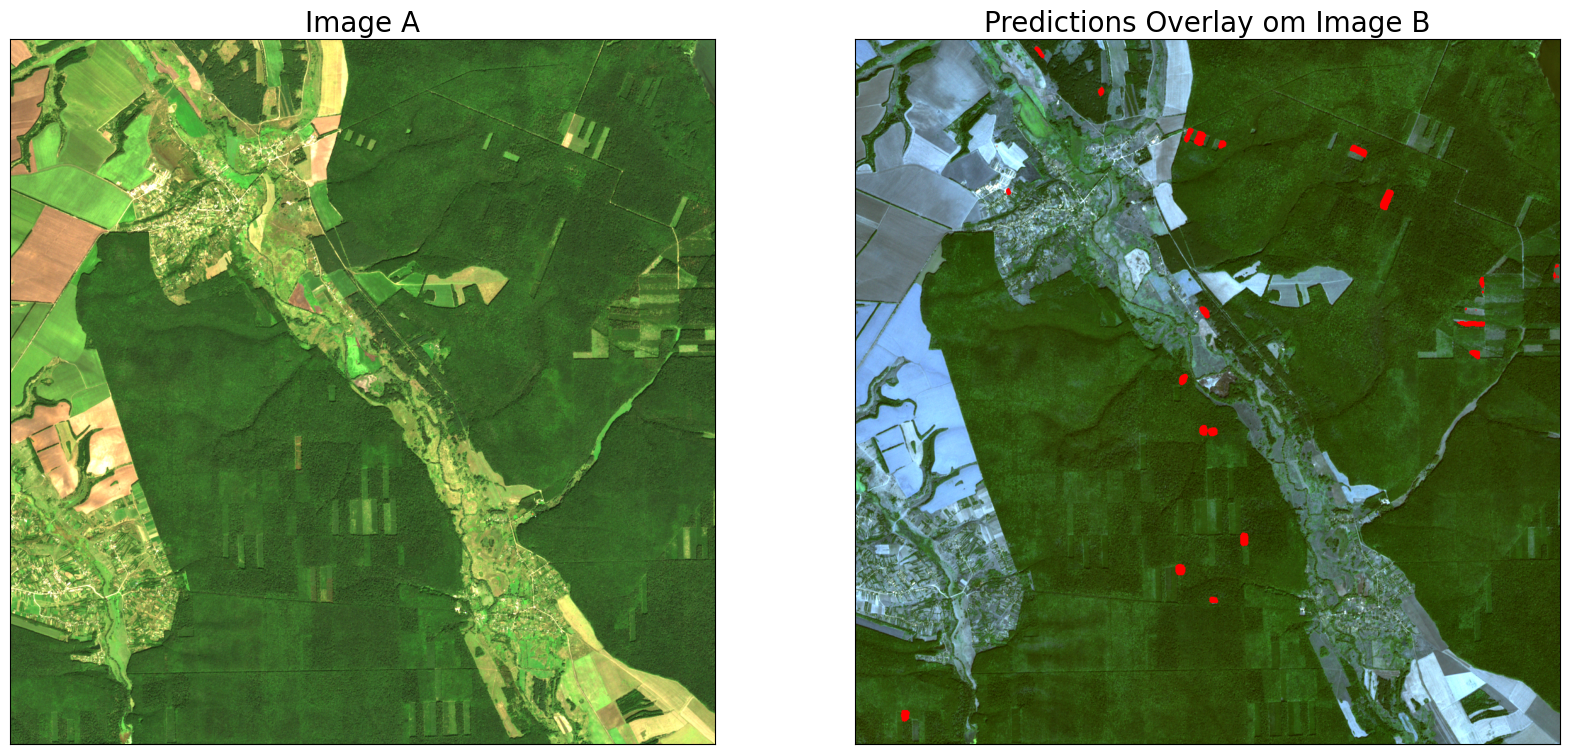

In [6]:
x_start = 24 # 14, 20
y_start = 29 # 14, 29
size = 5

# Crop the canvas to the selected region
canvasA_small = canvasA[patch_size*x_start:patch_size*(x_start+size), patch_size*y_start:patch_size*(y_start+size)]
canvasB_small = canvasB[patch_size*x_start:patch_size*(x_start+size), patch_size*y_start:patch_size*(y_start+size)]
canvas_gt_small = canvas_gt[patch_size*x_start:patch_size*(x_start+size), patch_size*y_start:patch_size*(y_start+size)]
canvas_pred_small = canvas_pred[patch_size*x_start:patch_size*(x_start+size), patch_size*y_start:patch_size*(y_start+size)]

# Prepare the overlay images
canvasA_small = percentile_stretch(canvasA_small, 0, 99)
canvasB_small = percentile_stretch(canvasB_small, 1, 99)
gt_overlay = np.where(canvas_gt_small[..., None] == 1, [1, 0, 0], canvasB_small)
pred_overlay = np.where(canvas_pred_small[..., None] == 1, [1, 0, 0], canvasB_small)


fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(canvasA_small)
ax[0].set_title("Image A", fontsize=20)
ax[1].imshow(pred_overlay)
ax[1].set_title("Predictions Overlay om Image B", fontsize=20)

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

